# <centre>Adventure Works Territory Sales Analysis</centre>

In [ ]:
import saspy
sas_session = saspy.SASsession()

In [2]:
libname project '/home/u63899982/ProjectFiles/';
*Initializing project Library;
filename adworks '/home/u63899982/ProjectFiles/AdventureWorks.xlsx';

*Creating filename variable since it will be used repeatedly;
* Importing SalesTerritory from excel file and loading into SAS dataset;

PROC IMPORT OUT=Project.SalesTerritory DATAFILE=adworks DBMS=xlsx REPLACE;
	SHEET="SalesTerritory";
	GETNAMES=YES;
RUN;

* Importing SalesOrderHeader from excel file and loading into SAS dataset;

PROC IMPORT OUT=Project.SalesOrderHeader DATAFILE=adworks DBMS=xlsx REPLACE;
	SHEET="SalesOrderHeader";
	GETNAMES=YES;
RUN;

TITLE "Listing of SalesTerritory";

PROC PRINT DATA=Project.SALESTERRITORY (obs=5);
RUN;

TITLE "Listing of SalesOrderHeader";

PROC PRINT DATA=Project.SalesOrderHeader (obs=5);
RUN;


The project library has been initialized, and filename variable adworks is created as it will be used further in the code<br>
- SalesTerritory sheet and SalesOrderHeader sheet are imported from the excel file and loaded into a SAS Dataset using Proc Import separately 
- The listing of SalesTerritory and SalesOrderHeader are shown using Proc Print and the number of observations (obs) to be shown for each are 10.

### PHASE 2: Data Cleaning

Data cleaning to be performed on two tables – <b>SalesOrderHeader and Territory</b>.<br><br>
1. Creating <b>SalesOrderHeader_Clean</b>
- Only <b>five</b> variables <b><span style="color:#800000">(<i>SalesOrderID, SalesOrderDetailID, OrderQty, ProductID, UnitPrice, LineTotal, ModifiedDate</i>)</span></b> were included in the clean dataset.
- Out of these, the data type of four variables <b><span style="color:#800000">(TotalDue, OnlineOrderFlag, OrderDate and TerritoryID)</span></b> was to be changed from <b>character</b> to <b>numeric</b>. 
- <b><span style="color:#800000">TotalDue</span></b> was formatted in a way such that the values in it have a <b>dollar sign with two decimal places</b> (the format dollar 13.2 was used).
- <b><span style="color:#800000">OrderDate</span></b> was converted from a SAS date to a readable format by using the <b>mmddyy10.</b> Format. <br>

2. Creating <b>Territory_Clean</b>
- Only <b>four</b> variables <b><span style="color:#800000">(<i>TerritoryID, Name, CountryRegionCode, GroupSalesYTD</i>)</span></b> were included in the clean dataset.
- The data type for <b><span style="color:#800000">SalesYTD</span></b> and <b><span style="color:#800000">TerritoryID</span></b> was changed from <b>character</b> to <b>numeric</b>.
- <b><span style="color:#800000">SalesYTD</span> </b>was formatted in a way such that the values in the variable have a <b>dollar sign with 2 decimal places</b> (the format dollar 13.2 was used).


In [3]:
DATA Project.SalesOrderHeader_Clean;
	set Project.Salesorderheader(keep=SalesOrderID OrderDate OnlineOrderFlag 
		TerritoryID TotalDue);
	TotalDue_Temp=INPUT(TotalDue, 13.);
	DROP TotalDue;
	RENAME TotalDue_Temp=TotalDue;
	OnlineOrderFlag_Temp=INPUT(OnlineOrderFlag, 8.);
	DROP OnlineOrderFlag;
	RENAME OnlineOrderFlag_Temp=OnlineOrderFlag;
	TerritoryID_Temp=INPUT(TerritoryID, 8.);
	DROP TerritoryID;
	RENAME TerritoryID_Temp=TerritoryID;
	OrderDate_Temp=INPUT(OrderDate, anydtdte.);
	DROP OrderDate;
	RENAME OrderDate_Temp=OrderDate;
RUN;

DATA Project.SalesOrderHeader_Clean;
	set Project.SalesOrderHeader_Clean;
	format OrderDate mmddyy10. TotalDue Dollar13.2;
run;

PROC PRINT DATA=PROJECT.salesorderheader_clean (OBS=10);
RUN;

PROC Contents Data=project.salesorderheader_clean;
RUN;

DATA Project.Territory_Clean;
	set Project.salesterritory (keep=TerritoryID Name CountryRegionCode Group 
		SalesYTD);
	SalesYTD_Temp=INPUT(SalesYTD, 13.);
	DROP SalesYTD;
	RENAME SalesYTD_Temp=SalesYTD;
	TerritoryID_Temp=INPUT(TerritoryID, 8.);
	DROP TerritoryID;
	RENAME TerritoryID_Temp=TerritoryID;
RUN;

DATA Project.Territory_Clean;
	set Project.Territory_Clean;
	format SalesYTD dollar13.2;
RUN;

PROC PRINT DATA=PROJECT.Territory_Clean (OBS=10);
RUN;

PROC Contents Data=project.Territory_Clean;
RUN;


Obs,SalesOrderID,TotalDue,OnlineOrderFlag,TerritoryID,OrderDate
1,43659,"$23,153.23",0,5,05/03/2011
2,43660,"$1,457.33",0,5,05/03/2011
3,43661,"$36,865.80",0,6,05/03/2011
4,43662,"$32,474.93",0,6,05/03/2011
5,43663,$472.31,0,4,05/03/2011
6,43664,"$27,510.41",0,1,05/03/2011
7,43665,"$16,158.70",0,1,05/03/2011
8,43666,"$5,694.86",0,4,05/03/2011
9,43667,"$6,876.36",0,3,05/03/2011
10,43668,"$40,487.72",0,6,05/03/2011


### PHASE 3 - Joining and Merging

<b>Merging Datasets</b><br>
- We first sort both the cleaned datasets by the <b><span style="color:#800000">TerritoryID</span></b> using <b>Proc Sort</b>.
- Created a new dataset <b><span style="color:#006400">SalesDetails </span></b> by using merge to merge <b><span style="color:#800000">salesorderheader_clean</span></b> and <b><span style="color:#800000">territory_clean </span></b> with the help of <b><span style="color:#800000">TerritoryID </span></b>
- Created <b><span style="color:#006400">Sales Analysis Table </span></b> by using proc sql on SalesDetails and then merged it with territory_clean for final output

In [5]:
*Merging salesorderheader_clean and territory_clean;
PROC sort data=project.salesorderheader_clean;
	by TerritoryID;
RUN;

PROC sort data=project.territory_clean;
	by TerritoryID;
RUN;

DATA project.SalesDetails;
	merge project.salesorderheader_clean project.territory_clean;
	by TerritoryID;
RUN;

*Creating Sales Analysis Table by using proc sql on SalesDetails and then merging it with territory_clean for final output;

proc sql;
	create table project.SalesAnalysis as select TerritoryID, count(TerritoryID) 
		as SubQty , sum(TotalDue) as SubTotalDue from project.SalesDetails group by 
		TerritoryID;
quit;

data project.SalesAnalysis;
	merge project.SalesAnalysis project.territory_clean;
	by TerritoryID;
	drop SalesLastYear CostYTD CostLastYear rowguid ModifiedDate;
	format SubTotalDue Dollar13.2;
run;

proc print data=project.SalesAnalysis;
run;


Obs,TerritoryID,SubQty,SubTotalDue,Name,CountryRegionCode,Group,SalesYTD
1,1,4594,$18061660.37,Northwest,US,North America,"$7,887,186.79"
2,2,352,"$7,820,209.63",Northeast,US,North America,"$2,402,176.85"
3,3,385,"$8,913,299.25",Central,US,North America,"$3,072,175.12"
4,4,6224,$27150594.59,Southwest,US,North America,$10510853.87
5,5,486,"$8,884,099.37",Southeast,US,North America,"$2,538,667.25"
6,6,4067,$18398929.19,Canada,CA,North America,"$6,771,829.14"
7,7,2672,"$8,119,749.35",France,FR,Europe,"$4,772,398.31"
8,8,2623,"$5,479,819.58",Germany,DE,Europe,"$3,805,202.35"
9,9,6843,$11814376.10,Australia,AU,Pacific,"$5,977,814.92"
10,10,3219,"$8,574,048.71",United Kingdom,GB,Europe,"$5,012,905.37"


### Phase 4 - Data Analysis

#### Descriptive Statistics

##### Total due of North American Region 

In [6]:
*Using proc template to modify output of proc means (sum) output;
proc template;
 edit base.summary;
  edit sum;
   format=dollar20.2;
  end;
 end;
run;
*1;
title "Total Due for North American regions";
proc means data=project.SalesAnalysis sum;
var SubTotalDue;
where Group="North America";
run; 


Analysis Variable : SubTotalDue
Sum
"$89,228,792.39"


##### Total Sales YTD for U.S.

In [8]:
title "Total Sales YTD for US";
proc means data=project.SalesAnalysis sum;
var SalesYTD;
where CountryRegionCode="US";
run;

Analysis Variable : SalesYTD
Sum
"$26,411,059.88"


##### Total Due from France and Germany

In [9]:
title "Total Due from France and Germany";
proc print data=project.SalesAnalysis;
var  CountryRegionCode SubTotalDue ;
where CountryRegionCode="FR" or CountryRegionCode="DE";
run;

Obs,CountryRegionCode,SubTotalDue
7,FR,"$8,119,749.35"
8,DE,"$5,479,819.58"


##### Total Sales YTD for Europe

In [10]:
title "Total Sales YTD for Europe";
proc means data=project.SalesAnalysis sum;
var SalesYTD;
where Group="Europe";
run;

Analysis Variable : SalesYTD
Sum
"$13,590,506.02"


##### Total territories in U.S

In [11]:
title "Total territories in U.S";
proc freq data=project.SalesAnalysis;
  table CountryRegionCode  /nopercent nocum;
 where CountryRegionCode= "US";
run;

#### Data Visualizations

##### Total Sales by country
- Following visualization showcases the Total Sales made in each Group (continent) using a vertical bar graph.
- Additionally, each bar graph also shows the proportion of sales made in each country in the group using separate color codes.
- It can be seen that <b>North American</b> group made the most sale


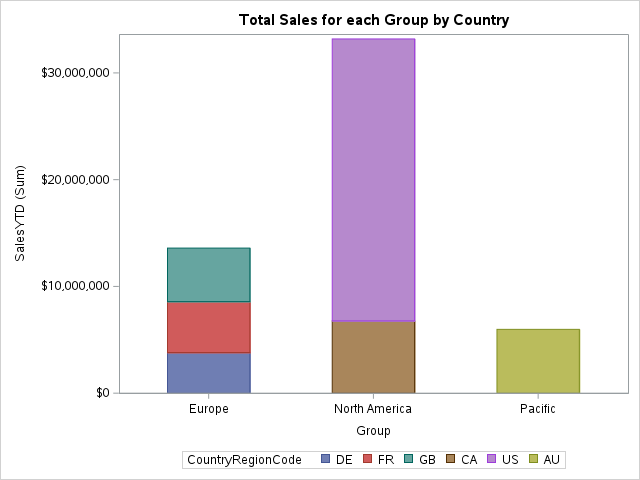

In [13]:
title "Total Sales for each Group by Country";
proc sgplot data=project.SalesAnalysis;
vbar Group  / group =CountryRegionCode response=SalesYTD barwidth=.5;
run;


##### Countries that placed the most orders
- Following visualization shows number of orders placed by each country in the dataset.
- We ran a proc freq to count orders by counting territory ID associated with each order from the salesorderheader_clean table and then merged the dataset with territory_clean table to build the following bar chart.
- Applied matte shade, datalabel and y axis gridlines to the graph.
- From the generate visualization, we can see that the <b>U.S.</b> has the most orders (12041)

TerritoryID,Frequency
1,4594
2,352
3,385
4,6224
5,486
6,4067
7,2672
8,2623
9,6843
10,3219

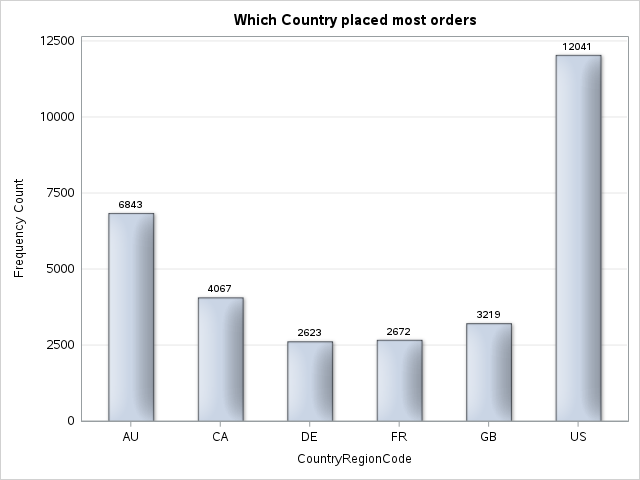

In [16]:
title "Count number of orders by counting appearance of each Territory IDs";
proc freq data=Project.salesorderheader_clean;
	table TerritoryID /nopercent nocum out=project.freqcnt outexpect sparse;
run;

PROC sort data=project.freqcnt;
	by TerritoryID;
RUN;

data project.MostSalesTerretory;
	merge project.freqcnt project.territory_clean;
	by TerritoryID;
	drop percent Name Group SalesYTD;
run;

title "Which Country placed most orders";
proc sgplot data=project.MostSalesTerretory;
	vbar CountryRegionCode / response=Count barwidth=.5 datalabel dataskin=matte;
	yaxis display=(noline noticks) grid;
run;
